# Mixture of Gaussians

# Plotting a model

In [1]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt

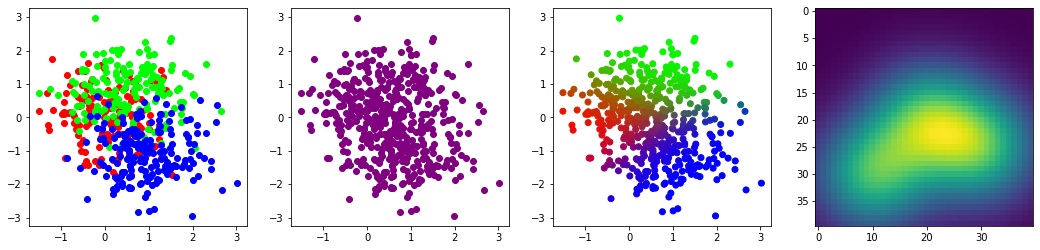

In [2]:
# The gaussians are the conditional probabilities given the coefficients
gaussians = [
    multivariate_normal([0, 0], np.array([[0.5,0],[0,0.5]])),
    multivariate_normal([0.5, 1], np.array([[0.5,0],[0,0.5]])),
    multivariate_normal([1, -1], np.array([[0.5,0],[0,0.5]]))
]

# The coefficients are like the prior probabilities of the model
coeffs = np.array([0.3, 0.3, 0.3]).reshape(1, len(gaussians)) 

k= len(gaussians)
colors = [(1,0,0), (0,1,0), (0,0,1)]

a = np.random.randint(0, k, 500) # Should be one hot but for easiness we just take the index (would be argmax)

created_data = np.vstack([gaussians[i].rvs(1) for i in a])

fig, plots = plt.subplots(ncols=4, nrows=1, figsize=(18,4))
for i in np.unique(a):
    subset = created_data[i == a]
    plots[0].scatter(subset[:,0], subset[:,1], color=colors[i])
    
plots[1].scatter(created_data[:,0], created_data[:,1], c='purple')

# The responsibility is the probability (or fraction of response) that a hidden gaussian has on an input example x
resps = coeffs  * np.stack([gaussian.pdf(created_data) for gaussian in gaussians], axis=1)
resps = resps / resps.sum(axis=1, keepdims=True)

plots[2].scatter(created_data[:, 0], created_data[:, 1], c=resps)

x, y = np.mgrid[-2:2:0.1, -2:2:0.1]
ps = np.dstack([x,y])

# So the above data is generated from the latent variables (possible since it is a generative model). We can also do
# classifications with this model by summing the probability of a point occuring given the latent models
plots[3].imshow(sum([coeffs[0][i] * gaussian.pdf(ps) for i, gaussian in enumerate(gaussians)]))

Left is the label of the generated data given by the argmax of the latent variable Z. In the middle is the 
marginal distribution p(x), note that the information about the variable z is lost (we marginalized over that one)
Right is the probability of the datapoints belonging to one of the latens gaussianss

# Learning the parameters of a mixture of gaussians

In [3]:
import pandas as pd

In [26]:
data = np.array([x.split()[1:3] for x in open('old_faithful.txt').readlines()[26:]]).astype(float)

data = (data - data.mean(axis=0)) / data.std(axis=0)

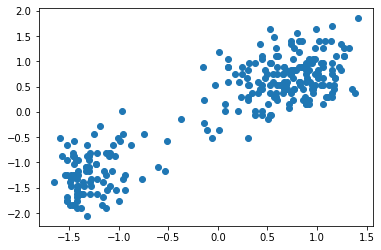

In [27]:
plt.scatter(data[:,0], data[:,1])

In [242]:
## Initialize the mean and cov for the 2 Gaussians using kmeans with k = 2

In [243]:
means = [np.random.uniform(data.min(), data.max(), 2).reshape(1, 2), np.random.uniform(data.min(), data.max(), 2).reshape(1, 2)]

In [244]:
for i in range(10):
    distances = [np.linalg.norm(data - mean, axis=1) for mean in means] 
    assignments = np.stack(distances, axis=1).argmax(axis=1)
    means = [data[np.argwhere(assignments == i).flatten()].mean(axis=0, keepdims=True) for i in range(2)]

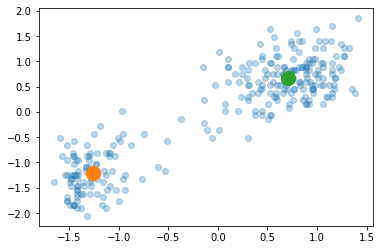

In [245]:
plt.scatter(data[:,0], data[:,1], alpha=0.30)
for x in means:
    plt.scatter(x[0][0], x[0][1], s=200)

In [246]:
from scipy.stats import multivariate_normal

def calculate_new_cov(data, mean, resps):
    new_cov = np.zeros((2, 2))

    for i in range(data.shape[0]):
        new_cov += resps[i] * (data[np.newaxis, i] - mean).T @ (data[np.newaxis, i] - mean)

    return new_cov / resps.sum()

In [247]:
# Initialize the gaussians, note that we already have a good initial guess using the K means algo 
gaussians = []

for i in range(2):
    gaussians.append(multivariate_normal(mean=means[i][0], cov=np.cov(data[assignments == i].T)))
    
# We can set the coefficients to be the number of data points assigned
coeffs = (np.unique(assignments, return_counts=True)[1] / assignments.size).reshape(1, 2)

In [249]:
print(np.log((coeffs * np.stack([gaussian.pdf(data) for gaussian in gaussians], axis=1)).sum(axis=1)).sum())

-387.05728992632646


In [251]:
previsous_nll = np.log((coeffs * np.stack([gaussian.pdf(data) for gaussian in gaussians], axis=1)).sum(axis=1)).sum()
for i in range(4):
    # Evaluate the conditional probability P(z|x), so the prob of seeing the gaussian given the data
    resps = np.stack([gaussian.pdf(data) for gaussian in gaussians], axis=1)
    resps /= resps.sum(axis=1, keepdims=True)

    # Update the means by weighing them with the responsibilities
    means = [(resps[:,i, np.newaxis] * data).sum(axis=0) / resps[:,i].sum() for i in range(2)]

    # Update the covariances using the new means
    covs = [calculate_new_cov(data, means[i], resps[:,i]) for i in range(2)]

    # Update the coefficients by taking the average responsibility for the data points
    coeffs = resps.sum(axis=0) / data.shape[0]

    # Evaluate the log likelihood, stop when it is no longer increasing
    nll = np.log((coeffs * np.stack([gaussian.pdf(data) for gaussian in gaussians], axis=1)).sum(axis=1)).sum()
    
    if nll >= previsous_nll:
        print('found best solution')
        break

found best solution


In [348]:
# The added value is that we now have a valid probability distribution marginalized over x (p(x))
# For example, we can plot the probability of a point in space belonging to the left cluster
# Furthermore you can take into account more complicated info, such as the covariance 
# While K Means will only be able to use some kind of distance function v

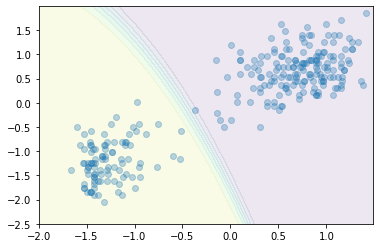

In [350]:
x, y = np.mgrid[-2:1.5:.01, -2.5:2:.01]
pos = np.dstack((x, y))
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,gaussians[0].pdf(pos) / sum([gaussian.pdf(pos) for gaussian in gaussians]), alpha=0.10)
ax2.scatter(data[:,0], data[:,1], alpha=0.30)

# Mixture of multinoullis

In [170]:
def calculate_class_cond_bernoulli(input_, probs): # Input is a binary vector (so only one and zero)
    prob = 1
    
    for i in range(len(probs)):
        prob *= bernoulli(probs[i]).pmf(input_[i])
        
    return prob

In [184]:
bitvector_size = int(8*8)
binar_input = np.random.randint(0, 2, (1, bitvector_size))

In [186]:
weights = [0.4, 0.2, 0.2, 0.1, 0.1] # Mixing weights
probs = [np.random.uniform(0, 1, bitvector_size), # These give the probability of the bit being 1
         np.random.uniform(0, 1, bitvector_size), 
         np.random.uniform(0, 1, bitvector_size), 
         np.random.uniform(0, 1, bitvector_size),               
         np.random.uniform(0, 1, bitvector_size)]

In [189]:
mixture = 0

for weight, prob in zip(weights, probs):
    mixture += weight * calculate_class_cond_bernoulli(binar_input[0], prob)

# Classification of the MNIST dataset

In [195]:
from sklearn.datasets import load_digits


In [197]:
digits = load_digits()

In [200]:
X = digits['data']
y = digits['target']

In [204]:
X = X[y < 3]

In [205]:
X.shape

(537, 64)

In [ ]:
k = 